<a href="https://colab.research.google.com/github/Omartaw98/Python-drug-discovery/blob/main/selective_COX_2_predicted_QSAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xgboost seaborn matplotlib

In [3]:
!pip install rdkit-pypi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 50.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


R2 Score: nan
RMSE: 0.399


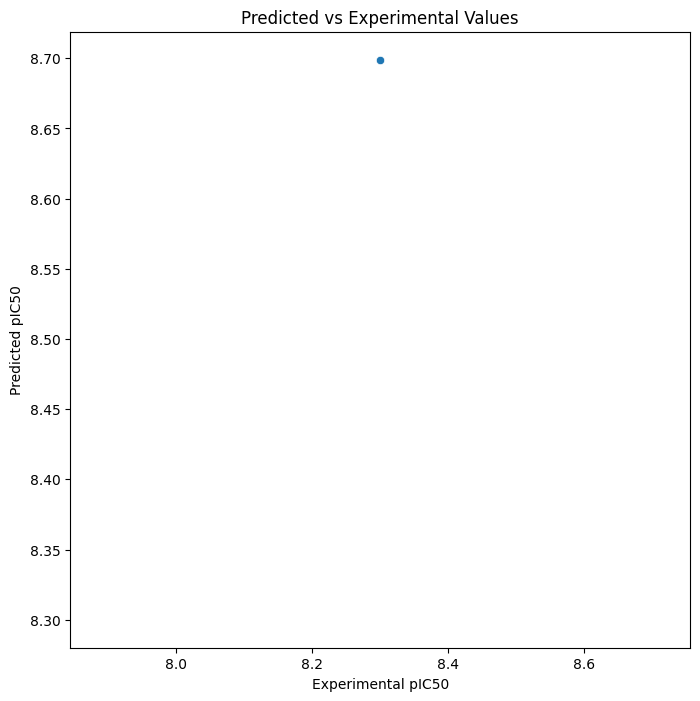


Top 10 Important Features:
    feature  importance
0        MW         1.0
48  Bit_249         0.0
55   Bit_89         0.0
54   Bit_64         0.0
53  Bit_875         0.0
52  Bit_667         0.0
51  Bit_503         0.0
50  Bit_367         0.0
49  Bit_272         0.0
47  Bit_198         0.0


In [4]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Fragments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

def create_initial_dataset():
    """Create sample COX-2 dataset"""
    data = {
        'SMILES': [
            'CC1=CC=C(C=C1)S(=O)(=O)NC(=O)NC2=CC=C(C=C2)OC',  # Celecoxib
            'CC1=C(C=C(C=C1)S(=O)(=O)NC(=O)NC2=CC=C(C=C2)OC)C',  # Valdecoxib
            'CC1=CC=C(C=C1)C2=C(C(=O)OC2)C3=CC=C(C=C3)F',  # Rofecoxib
            'CC1=CC=C(C=C1)C2=C(C(=O)OC2)C3=CC=CC=C3'  # Example analog
        ],
        'pIC50': [8.7, 8.3, 8.1, 7.9]
    }
    return pd.DataFrame(data)

def calculate_molecular_descriptors(smiles):
    """Calculate molecular descriptors using RDKit"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    descriptors = {}
    # Basic descriptors
    descriptors['MW'] = Descriptors.ExactMolWt(mol)
    descriptors['LogP'] = Descriptors.MolLogP(mol)
    descriptors['TPSA'] = Descriptors.TPSA(mol)
    descriptors['HBA'] = Descriptors.NumHAcceptors(mol)
    descriptors['HBD'] = Descriptors.NumHDonors(mol)

    # COX-2 specific descriptors
    descriptors['SulfonamideGroups'] = Fragments.fr_sulfonamd(mol)
    descriptors['AromaticRings'] = Descriptors.NumAromaticRings(mol)
    descriptors['AliphaticRings'] = Descriptors.NumAliphaticRings(mol)
    descriptors['sp3Carbons'] = Descriptors.FractionCSP3(mol)

    # Fragment counts
    descriptors['MethoxyGroups'] = Fragments.fr_methoxy(mol)
    descriptors['CarboxylGroups'] = Fragments.fr_COO(mol)
    descriptors['AmideGroups'] = Fragments.fr_amide(mol)

    # Morgan fingerprints
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    fp_bits = list(fp.GetOnBits())
    for bit in fp_bits:
        descriptors[f'Bit_{bit}'] = 1

    return descriptors

def prepare_dataset(df):
    """Prepare dataset from DataFrame"""
    descriptor_list = []
    for smiles in df['SMILES']:
        desc = calculate_molecular_descriptors(smiles)
        descriptor_list.append(desc)

    descriptor_df = pd.DataFrame(descriptor_list)
    return descriptor_df.fillna(0), df['pIC50']

def train_qsar_model(X, y, model_type='xgboost'):
    """Train QSAR model"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if model_type == 'xgboost':
        model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6)
    else:
        model = RandomForestRegressor(n_estimators=200, max_depth=10)

    model.fit(X_train_scaled, y_train)

    importance = model.feature_importances_
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': importance
    }).sort_values('importance', ascending=False)

    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return model, scaler, feature_importance, (X_test_scaled, y_test, y_pred, r2, rmse)

def plot_results(y_test, y_pred):
    """Plot predicted vs experimental values"""
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Experimental pIC50')
    plt.ylabel('Predicted pIC50')
    plt.title('Predicted vs Experimental Values')
    plt.show()

# Run workflow
df = create_initial_dataset()
X, y = prepare_dataset(df)
model, scaler, feature_imp, (X_test, y_test, y_pred, r2, rmse) = train_qsar_model(X, y)

# Print results
print(f"R2 Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# Plot results
plot_results(y_test, y_pred)

# Show top features
print("\nTop 10 Important Features:")
print(feature_imp.head(10))

In [6]:
# Predict new compounds
new_smiles = [
    'CC1=CC=C(C=C1)S(=O)(=O)NC(=O)NC2=CC=C(C=C2)OCC',  # Modified Celecoxib
    'CC1=CC=C(C=C1)C2=C(C(=O)OC2)C3=CC=C(C=C3)Cl'   # Modified Rofecoxib
]

descriptor_list = []
for smiles in new_smiles:
    desc = calculate_molecular_descriptors(smiles)
    descriptor_list.append(desc)

descriptor_df = pd.DataFrame(descriptor_list)
descriptor_df = descriptor_df.fillna(0)

# Get the column names from the training data
train_columns = X.columns

# Add missing columns to the new data
for col in train_columns:
    if col not in descriptor_df.columns:
        descriptor_df[col] = 0

# Remove extra columns from the new data
descriptor_df = descriptor_df[train_columns]

scaled_descriptors = scaler.transform(descriptor_df)
predictions = model.predict(scaled_descriptors)

for smiles, pred in zip(new_smiles, predictions):
    print(f"SMILES: {smiles}")
    print(f"Predicted pIC50: {pred:.2f}")

SMILES: CC1=CC=C(C=C1)S(=O)(=O)NC(=O)NC2=CC=C(C=C2)OCC
Predicted pIC50: 8.70
SMILES: CC1=CC=C(C=C1)C2=C(C(=O)OC2)C3=CC=C(C=C3)Cl
Predicted pIC50: 8.10
